In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
import time
import pylab
%matplotlib inline

In [3]:
non_vehicle_paths = ["non-vehicles/Extras/*.png", "non-vehicles/GTI/*.png"]

vehicle_paths = ["vehicles/GTI_Far/*.png", "vehicles/GTI_Left/*.png", "vehicles/GTI_Right/*.png",
                    "vehicles/GTI_MiddleClose/*.png", "vehicles/KITTI_extracted/*.png"]

non_vehicle_filenames = []

vehicle_filenames = []

for path in non_vehicle_paths:
    non_vehicle_filenames += glob.glob(path)
    
for path in vehicle_paths:
    vehicle_filenames += glob.glob(path)
    
print(len(non_vehicle_filenames))
print(len(vehicle_filenames))

8968
8792


### Getting windows

In [4]:
window_list=[]

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    plt.imshow(imcopy)
    for bbox in bboxes:
#         print((bbox[0], bbox[1]))
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0]==None or y_start_stop[0]==None:
        x_start_stop=[0,img.shape[1]]
        y_start_stop=[0,img.shape[0]]
    
    x_win_start=x_start_stop[0]
    x_win_end=x_win_start+xy_window[0]
    y_win_start=y_start_stop[0]
    y_win_end=y_win_start+xy_window[1]
    window_list = []
    while y_win_end<=y_start_stop[1]:
        while x_win_end<=x_start_stop[1]:
            pt1=(int(x_win_start),int(y_win_start))
            pt2=(int(x_win_end),int(y_win_end))
            x_win_start=x_win_start+(1-xy_overlap[0])*xy_window[0]
            x_win_end=x_win_start+xy_window[0]
            window_list.append((pt1,pt2))
#             print((pt1,pt2))
        y_win_start=y_win_start+(1-xy_overlap[1])*xy_window[1]
        x_win_start=x_start_stop[0]
        x_win_end=x_win_start+xy_window[0]
        y_win_end=y_win_start+xy_window[1]
    return window_list

273
196
85
216
770


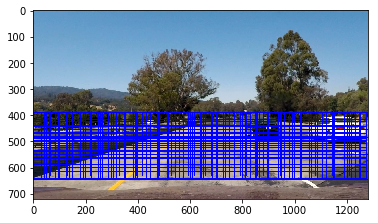

In [7]:
img=cv2.imread("C:/Users/Abhishek/Desktop/CarND-Vehicle-Detection-master/test_images/test1.jpg")
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img)
x_start_stop=[0, 1280]
y_start_stop=[390, 660]
xy_window=(64,64)
xy_overlap=(0.5,0.5)
# wl1=slide_window(img,x_start_stop,y_start_stop,xy_window,(0.5,0.5))
# wl2=slide_window(img,x_start_stop,y_start_stop,(64,64),(0.5,0.5))
# wl3=slide_window(img,x_start_stop,y_start_stop,(256,128),(0.5,0.5))
# wl4=slide_window(img,x_start_stop,y_start_stop,(128,128),(0.5,0.5))
wl1=slide_window(img,x_start_stop,y_start_stop,xy_window,(0.5,0.5))
wl2=slide_window(img,x_start_stop,y_start_stop,(140,90),(0.7,0.7))
wl3=slide_window(img,x_start_stop,y_start_stop,(220,110),(0.7,0.7))
wl4=slide_window(img,x_start_stop,y_start_stop,(100,50),(0.5,0.5))
# wl5=slide_window(img,x_start_stop,y_start_stop,(32,32),(0.5,0.5))
print(len(wl1))
print(len(wl2))
print(len(wl3))
print(len(wl4))

wl1_img = draw_boxes(img, wl1, color=(0, 0, 255), thick=2)
wl2_img = draw_boxes(wl1_img, wl2, color=(0, 0, 255), thick=2)
wl3_img = draw_boxes(wl2_img, wl3, color=(0, 0, 255), thick=2)
wl4_img = draw_boxes(wl3_img, wl4, color=(0, 0, 255), thick=2)
# wl5_img = draw_boxes(wl4_img, wl5, color=(0, 0, 255), thick=2)
plt.imshow(wl4_img)
wl1.extend(wl2)
wl1.extend(wl3)
wl1.extend(wl4)
# wl1.extend(wl5)
print(len(wl1))
wl1_img = draw_boxes(img, wl1, color=(0, 0, 255), thick=2)
plt.imshow(wl1_img)

### Feature Extraction

In [8]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0],bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1],bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2],bins=nbins, range=bins_range)
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))    
    return hist_features

def bin_spatial(img, color_space='RGB', size=(32, 32)):
    small_img = cv2.resize(img, size)
    features = small_img.ravel()
    return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True,feature_vec=True):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if vis:
        hog_features, hog_image = hog(gray, orientations=orient,
                              pixels_per_cell=(pix_per_cell, pix_per_cell), 
                              cells_per_block=(cell_per_block, cell_per_block), 
                              visualise=vis, feature_vector=feature_vec,
                              block_norm="L2-Hys")
        return hog_features, hog_image
    else:
        hog_features=hog(gray, orientations=orient,
                              pixels_per_cell=(pix_per_cell, pix_per_cell), 
                              cells_per_block=(cell_per_block, cell_per_block), 
                              visualise=vis, feature_vector=feature_vec,
                              block_norm="L2-Hys")
        return hog_features
    
def extract_features(image):
    f1=color_hist(image,32,(0, 256))
    f2=bin_spatial(image,'RGB',(32,32))
    f3=get_hog_features(image,9,8,2,False,True)
    f4=np.concatenate((f1,f2,f3))
#     print(f4.shape)
    return f4

In [9]:
# img=cv2.imread("C:/Users/Abhishek/Desktop/CarND-Vehicle-Detection-master/vehicles/GTI_Far/image0001.png")
# print(extract_features(img))

non_vehicle_paths = ["non-vehicles/Extras/*.png", "non-vehicles/GTI/*.png"]

vehicle_paths = ["vehicles/GTI_Far/*.png", "vehicles/GTI_Left/*.png", "vehicles/GTI_Right/*.png",
                    "vehicles/GTI_MiddleClose/*.png", "vehicles/KITTI_extracted/*.png"]

non_vehicle_filenames = []

vehicle_filenames = []
x_train=[]
y_train=[]
for path in non_vehicle_paths:
    non_vehicle_filenames += glob.glob(path)
    
for path in vehicle_paths:
    vehicle_filenames += glob.glob(path)
    
for f in vehicle_filenames:
    img=cv2.imread(f)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_train.append(extract_features(img))
    y_train.append(1)
for f in non_vehicle_filenames:
    img=cv2.imread(f)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_train.append(extract_features(img))
    y_train.append(0)
    
print(len(x_train))
print(len(y_train))

# X_scaler = StandardScaler().fit(X)

17760
17760


In [10]:
print(len(x_train))
print(len(y_train))

X_train=np.asarray(x_train).astype(np.float64)
Y_train=np.asarray(y_train)
print(X_train.shape)
print(Y_train.shape)


X_train_split, X_test, Y_train_split, Y_test = train_test_split(X_train, Y_train, test_size=0.2)
print(X_train_split.shape)
print(X_test.shape)
print(Y_train_split.shape)
print(Y_test.shape)
x_scaler = StandardScaler().fit(X_train_split)
scaled_x_train = x_scaler.transform(X_train_split)
scaled_x_test=x_scaler.transform(X_test)

17760
17760
(17760, 4932)
(17760,)
(14208, 4932)
(3552, 4932)
(14208,)
(3552,)


In [12]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train_split, Y_train_split)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, Y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', Y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

47.88 Seconds to train SVC...
Test Accuracy of SVC =  0.9631
My SVC predicts:  [0 1 1 1 0 0 1 1 1 1]
For these 10 labels:  [0 1 1 1 0 0 1 1 1 1]
0.004 Seconds to predict 10 labels with SVC


72.0
[ 6.  4.]


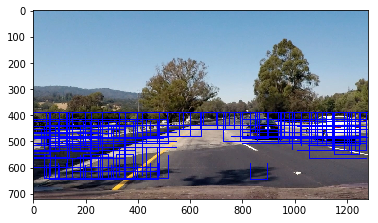

In [13]:
def search_window(image):
    on_windows = []
    for win in wl1:
#         print(win)
        test_img = cv2.resize(image[win[0][1]:win[1][1], win[0][0]:win[1][0]], (64, 64))
        features=extract_features(test_img)
        test_features = x_scaler.transform(np.asarray(features).reshape(1, -1))
#         print(test_features.shape)
        prediction=svc.predict(test_features)
        if prediction==1:
            on_windows.append(win)
    return on_windows

img=cv2.imread("C:/Users/Abhishek/Desktop/CarND-Vehicle-Detection-master/test_images/test4.jpg")
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
F = pylab.gcf()
DPI = F.get_dpi()
print(DPI)
DefaultSize = F.get_size_inches()
print(DefaultSize)
# print(img.shape)
# new_img=cv2.resize(img[400:432, 0:32,:],(64,64))
# print(new_img.shape)
hot_windows=search_window(img)
out_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=2)
plt.imshow(out_img)
plt.imsave("./ab.jpg",out_img)

### Heatmap Approach

13


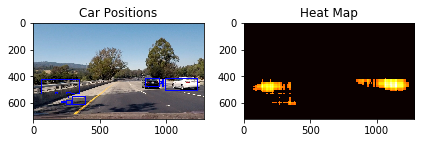

In [21]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heat,hot_windows)
heat = apply_threshold(heat,13)

# plt.imshow(heat,cmap='hot')
# heatmap = np.clip(heat, 0, 255)
# plt.imshow(heatmap,cmap='hot')
labels = label(heat)
draw_img = draw_labeled_bboxes(np.copy(img), labels)
print(labels[1])

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.imsave("./ab_draw.jpg",draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heat, cmap='hot')
plt.imsave("./ab_heat.jpg",heat)
plt.title('Heat Map')
fig.tight_layout()

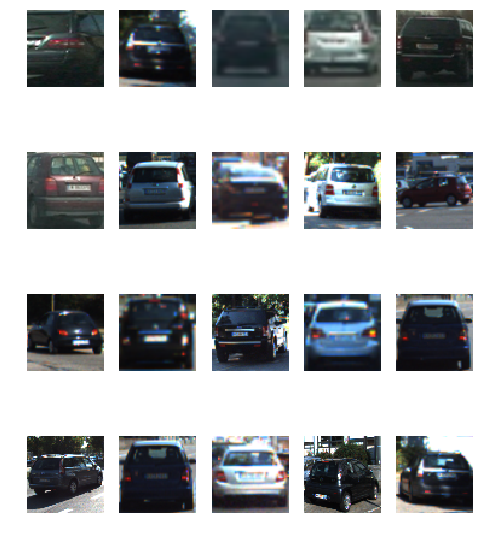

In [4]:
for i in range(5):
    for j in range(4):
        image = plt.imread(vehicle_filenames[car_indices[4*i + j]])
        plt.subplot(4,5,4*i + j + 1)
        plt.axis('off')
        plt.imshow(image)

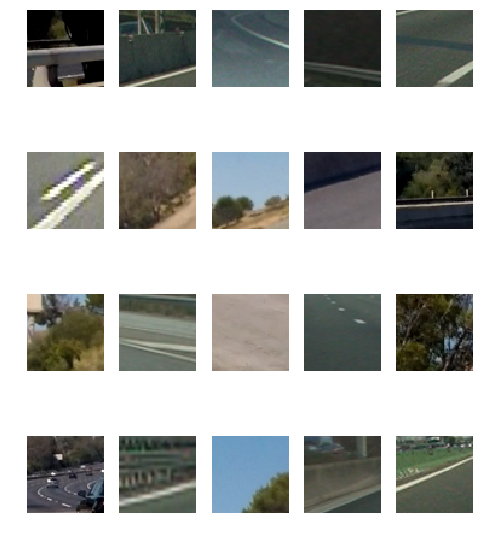

In [5]:
for i in range(5):
    for j in range(4):
        image = plt.imread(non_vehicle_filenames[notcar_indices[4*i + j]])
        plt.subplot(4,5,4*i + j + 1)
        plt.axis('off')
        plt.imshow(image)

Text(0.5,1,'B Histogram')

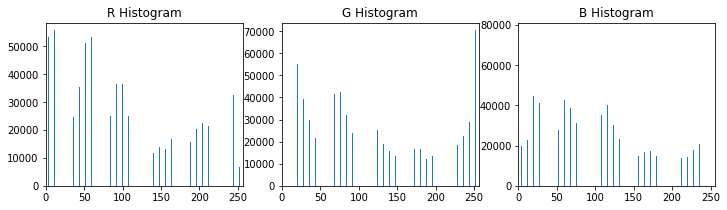

In [23]:
# Read in the image
image = plt.imread('cutout1.jpg')

# Take histograms in R, G, and B
rhist = np.histogram(image[:,:,0], bins=32, range=(0, 256))
ghist = np.histogram(image[:,:,1], bins=32, range=(0, 256))
bhist = np.histogram(image[:,:,2], bins=32, range=(0, 256))

# Generating bin centers
bin_edges = rhist[1]
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

# Plot a figure with all three bar charts
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, rhist[0])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(132)
plt.bar(bin_centers, ghist[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(133)
plt.bar(bin_centers, bhist[0])
plt.xlim(0, 256)
plt.title('B Histogram')

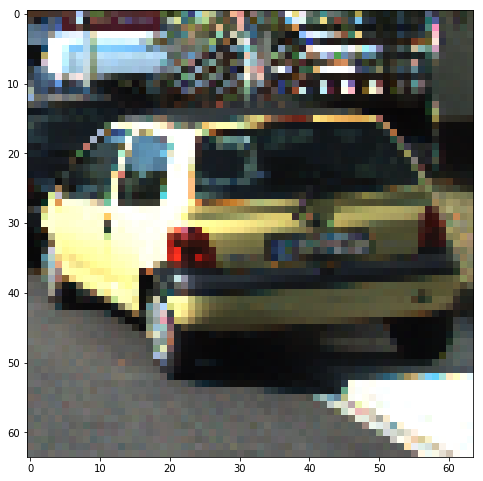

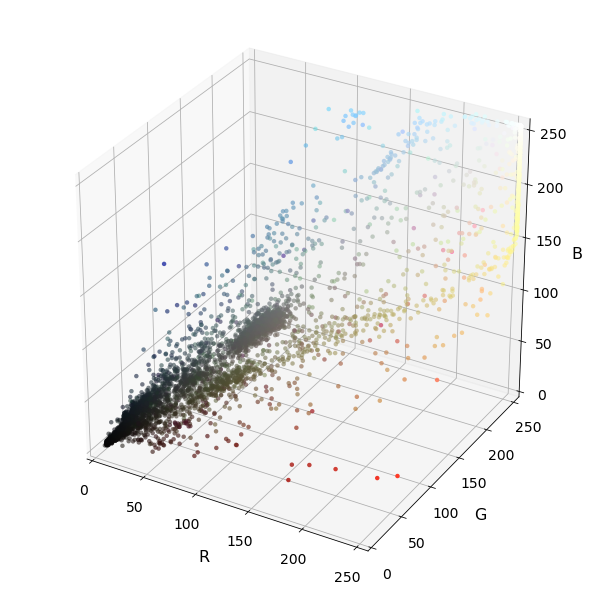

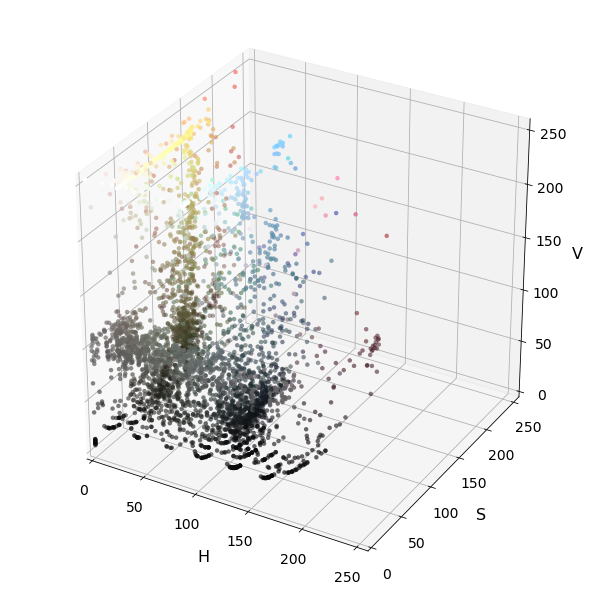

In [25]:
# Section 15: Explore Colorspaces
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


# Read a color image
img = cv2.imread("25.png")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
plt.imshow(img_small_RGB)

img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

# Note to self: Talk About Spatial Binning of Color

# Gradient Features

## Gradients as unique signature of an object
![image](gradients.png)

## HOG Features
HOG technique was first presented in 2005 by a person of Indian origin Navneet Dalal. [Video](https://www.youtube.com/watch?v=7S5qXET179I) , [Research Paper](http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf)

They used HOG features + SVM to detect pedestrians in a camera feed.

![Training Images](trainingimages.png)
![pedestrians](pedestrians.png)

/Users/subodh/miniconda3/envs/carnd-term11/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Text(0.5,1,'HOG Visualization')

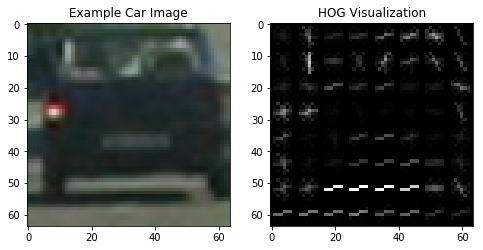

In [26]:
# Section 20
from skimage.feature import hog
        
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

# Generate a random index to look at a car image
random_car_index = np.random.choice(20)

# Read in the image
image = plt.imread(vehicle_filenames[random_car_index])

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')